In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud

import nltk
import re
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk import word_tokenize,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from collections import Counter



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset and only including the important/needed ones

In [208]:
df = pd.read_csv('spam.csv',encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Checking the number of ham vs spam emails in dataset

label
0    4825
1     747
Name: count, dtype: int64


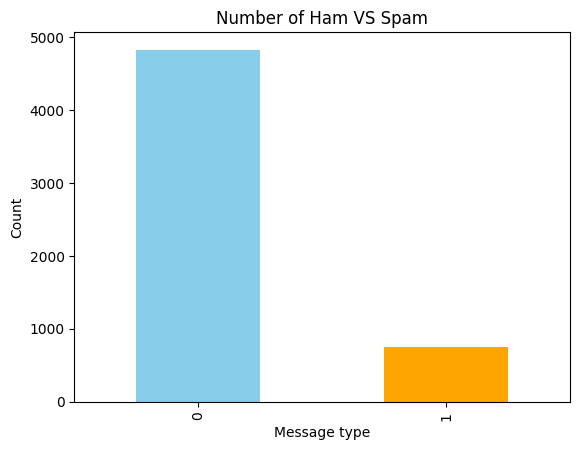

In [209]:
df['label'] = df['label'].map({'ham': 0, 'spam' : 1})
label_number = df['label'].value_counts()
print(label_number)

label_number.plot(kind ='bar', color =['skyblue', 'orange'])
plt.title('Number of Ham VS Spam')
plt.xlabel('Message type')
plt.ylabel('Count')
plt.show()

In [210]:
df['email_length'] = df['text'].apply(len)
correlation = df[['label', 'email_length']].corr()
correlation
# a correlation value of 0.387 indicates that spam emails do have longer emails

,label,email_length
label,1.000000,0.387285
email_length,0.387285,1.000000


In [211]:
df_cleaned = df.copy()
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text
df_cleaned['Words'] = df_cleaned['text'].apply(clean_text)
df_cleaned

,label,text,email_length,Words
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,161,this is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?,37,will ì b going to esplanade fr home
5569,0,"Pity, * was in mood for that. So...any other s...",57,pity was in mood for that soany other suggest...
5570,0,The guy did some bitching but I acted like i'd...,125,the guy did some bitching but i acted like id ...


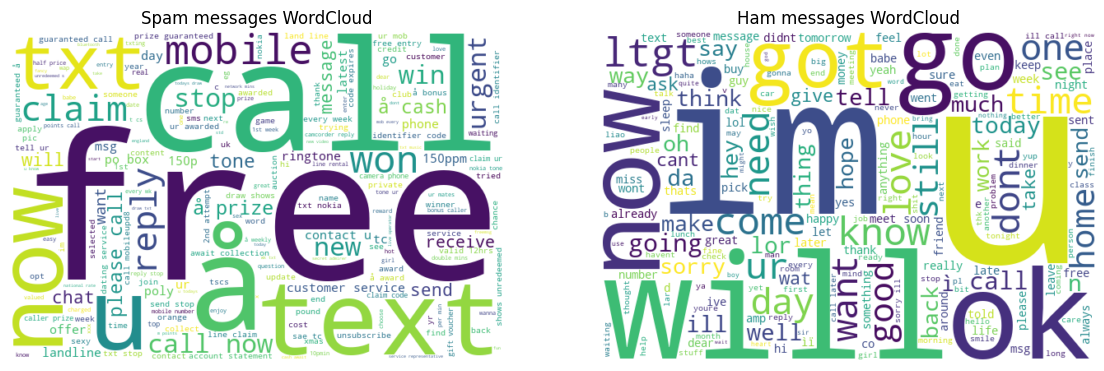

In [212]:
spam_words = '  '.join(df_cleaned[df_cleaned['label'] == 1]['Words'])
ham_words = '  '.join(df_cleaned[df_cleaned['label'] == 0] ['Words'])

plt.figure(figsize=(14,6))

spam_wordcloud = WordCloud(width =600, height =400, background_color = 'white').generate(spam_words)
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Spam messages WordCloud')

ham_wordcloud = WordCloud(width =600, height =400, background_color = 'white').generate(ham_words)
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Ham messages WordCloud')

plt.show()

In [213]:
spam_words = '  '.join(df_cleaned[df_cleaned['label'] == 1]['Words']).split()
ham_words = '  '.join(df_cleaned[df_cleaned['label'] == 0] ['Words']).split()

spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

print("Most used Spam words: ", spam_word_freq.most_common(10))
print("\nMost used Ham Words", ham_word_freq.most_common(10))


Most used Spam words:  [('to', 686), ('a', 376), ('call', 347), ('you', 287), ('your', 263), ('free', 216), ('the', 204), ('for', 203), ('now', 189), ('or', 188)]

Most used Ham Words [('i', 2185), ('you', 1837), ('to', 1554), ('the', 1118), ('a', 1052), ('u', 972), ('and', 848), ('in', 811), ('me', 756), ('my', 743)]


In [214]:
def remove_short_words(text):
    words = text.split()
    return ' '.join([word for word in words if len(word) > 2])

df_cleaned['Filtered_Words'] = df_cleaned['Words'].apply(remove_short_words)
df_cleaned.head()

,label,text,email_length,Words,Filtered_Words
0,0,"Go until jurong point, crazy.. Available only ...",111,go until jurong point crazy available only in ...,until jurong point crazy available only bugis ...
1,0,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni,lar joking wif oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry in 2 a wkly comp to win fa cup fina...,free entry wkly comp win cup final tkts 21st m...
3,0,U dun say so early hor... U c already then say...,49,u dun say so early hor u c already then say,dun say early hor already then say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,nah i dont think he goes to usf he lives aroun...,nah dont think goes usf lives around here though


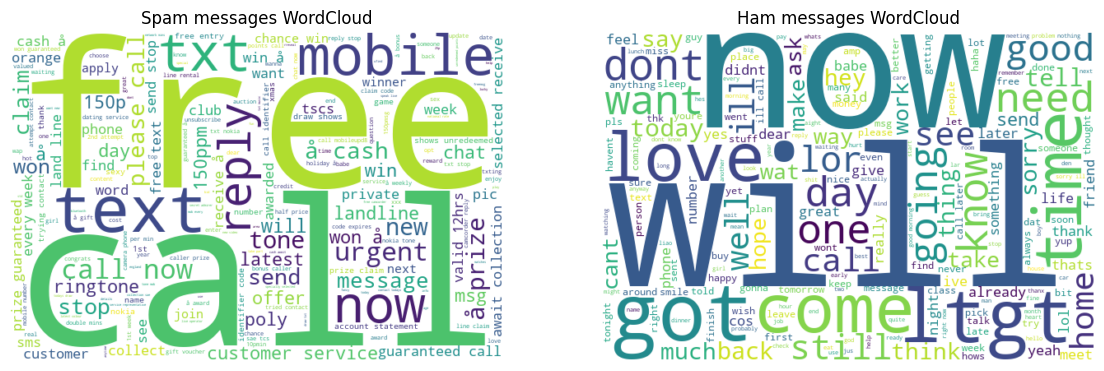

In [215]:
spam_words = '  '.join(df_cleaned[df_cleaned['label'] == 1]['Filtered_Words'])
ham_words = '  '.join(df_cleaned[df_cleaned['label'] == 0] ['Filtered_Words'])

plt.figure(figsize=(14,6))

spam_wordcloud = WordCloud(width =600, height =400, background_color = 'white').generate(spam_words)
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Spam messages WordCloud')

ham_wordcloud = WordCloud(width =600, height =400, background_color = 'white').generate(ham_words)
plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Ham messages WordCloud')

plt.show()

In [216]:
spam_words = '  '.join(df_cleaned[df_cleaned['label'] == 1]['Filtered_Words']).split()
ham_words = '  '.join(df_cleaned[df_cleaned['label'] == 0] ['Filtered_Words']).split()

spam_word_freq = Counter(spam_words)
ham_word_freq = Counter(ham_words)

print("Most used Spam words: ", spam_word_freq.most_common(10))
print("\nMost used Ham Words", ham_word_freq.most_common(10))

Most used Spam words:  [('call', 347), ('you', 287), ('your', 263), ('free', 216), ('the', 204), ('for', 203), ('now', 189), ('txt', 150), ('have', 135), ('from', 128)]

Most used Ham Words [('you', 1837), ('the', 1118), ('and', 848), ('for', 501), ('that', 486), ('have', 438), ('but', 418), ('your', 414), ('are', 409), ('not', 406)]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14112\1334924610.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'label', y = 'email_length', data = df, palette= 'pastel')


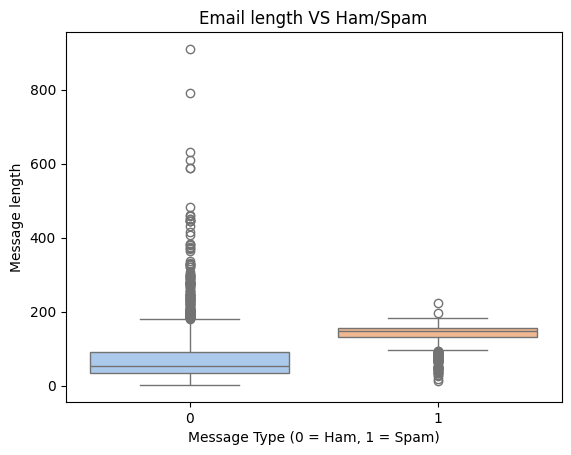

In [217]:
sns.boxplot(x = 'label', y = 'email_length', data = df, palette= 'pastel')
plt.title('Email length VS Ham/Spam')
plt.ylabel('Message length')
plt.xlabel('Message Type (0 = Ham, 1 = Spam)')
plt.show()

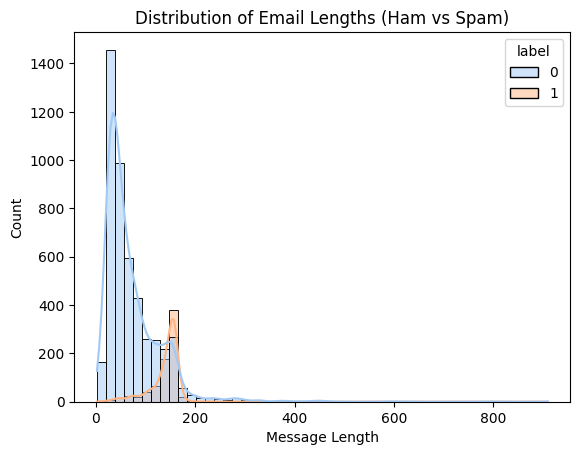

In [218]:
sns.histplot(data=df, x='email_length', hue='label', bins=50, kde=True, palette='pastel')
plt.title("Distribution of Email Lengths (Ham vs Spam)")
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()


# Cleaning Outliers

In [219]:
upper = df_cleaned['email_length'].quantile(0.99)
lower = df_cleaned['email_length'].quantile(0.01)

df_cleaned = df_cleaned[(df_cleaned['email_length'] >= lower) & (df_cleaned['email_length'] <= upper)]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14112\1024019316.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = 'label', y = 'email_length', data = df_cleaned, palette= 'pastel')


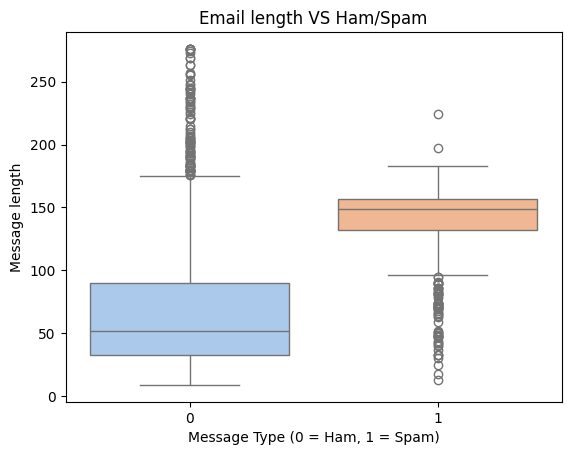

In [220]:
sns.boxplot(x = 'label', y = 'email_length', data = df_cleaned, palette= 'pastel')
plt.title('Email length VS Ham/Spam')
plt.ylabel('Message length')
plt.xlabel('Message Type (0 = Ham, 1 = Spam)')
plt.show()

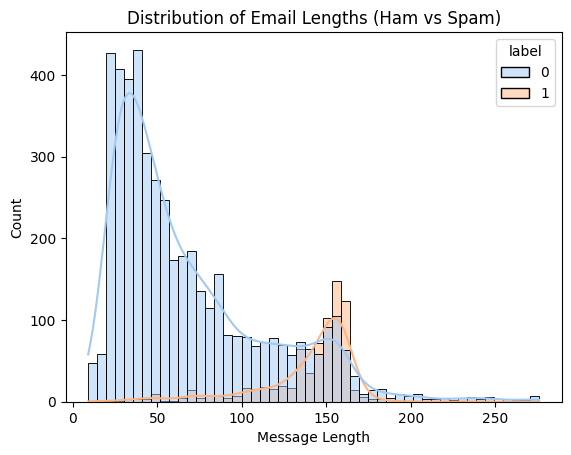

In [221]:
sns.histplot(data=df_cleaned, x='email_length', hue='label', bins=50, kde=True, palette='pastel')
plt.title("Distribution of Email Lengths (Ham vs Spam)")
plt.xlabel("Message Length")
plt.ylabel("Count")
plt.show()

# Model Fitting

In [222]:
# X has the values of the text that had already removed the short words
X = df_cleaned[['email_length', 'Filtered_Words']]
y = df_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [223]:
vectorizer = TfidfVectorizer(stop_words = 'english')
scaler = MinMaxScaler()
preprocessor  = ColumnTransformer(
    transformers=[
        ('text', vectorizer, 'Filtered_Words'),
        ('Length', scaler, ['email_length'])
    ]
)

model = MultinomialNB()

text_clf = make_pipeline(preprocessor, model)
text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(report)
print(conf_matrix)
print("Accuracy: ", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       957
           1       1.00      0.72      0.84       138

    accuracy                           0.96      1095
   macro avg       0.98      0.86      0.91      1095
weighted avg       0.97      0.96      0.96      1095

[[957   0]
 [ 39  99]]
Accuracy:  0.9643835616438357


In [224]:
vectorizer_Count = CountVectorizer(stop_words = 'english')
scaler = MinMaxScaler()
preprocessor  = ColumnTransformer(
    transformers=[
        ('text', vectorizer_Count, 'Filtered_Words'),
        ('Length', scaler, ['email_length'])
    ]
)
model = MultinomialNB()
text_clf_count = make_pipeline(preprocessor, model)
text_clf_count.fit(X_train, y_train)
y_pred_count = text_clf_count.predict(X_test)
report_count = classification_report(y_test, y_pred_count)
conf_matrix_count = confusion_matrix(y_test, y_pred_count)
print(report_count)
print(conf_matrix_count)
print("Accuracy: ", accuracy_score(y_test, y_pred_count))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       957
           1       0.93      0.90      0.91       138

    accuracy                           0.98      1095
   macro avg       0.96      0.94      0.95      1095
weighted avg       0.98      0.98      0.98      1095

[[947  10]
 [ 14 124]]
Accuracy:  0.9780821917808219


In [225]:
vectorizer = TfidfVectorizer(stop_words = 'english')
scaler = MinMaxScaler()
preprocessor  = ColumnTransformer(
    transformers=[
        ('text', vectorizer, 'Filtered_Words'),
        ('Length', scaler, ['email_length'])
    ]
)

model = LogisticRegression()
text_clf_Log = make_pipeline(preprocessor, model)
text_clf_Log.fit(X_train, y_train)
y_pred_Log = text_clf_Log.predict(X_test)
report_Log = classification_report(y_test, y_pred_Log)
conf_matrix_Log = confusion_matrix(y_test, y_pred_Log)
print(report_Log)
print(conf_matrix_Log)
print("Accuracy: ", accuracy_score(y_test, y_pred_Log))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       957
           1       0.95      0.77      0.85       138

    accuracy                           0.97      1095
   macro avg       0.96      0.88      0.91      1095
weighted avg       0.96      0.97      0.96      1095

[[951   6]
 [ 32 106]]
Accuracy:  0.965296803652968


Text(70.72222222222221, 0.5, 'Actual')

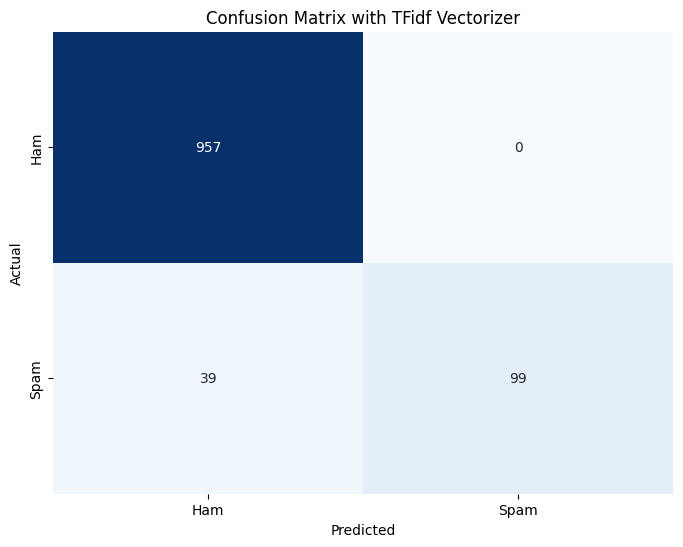

In [226]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot = True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix with TFidf Vectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(70.72222222222221, 0.5, 'Actual')

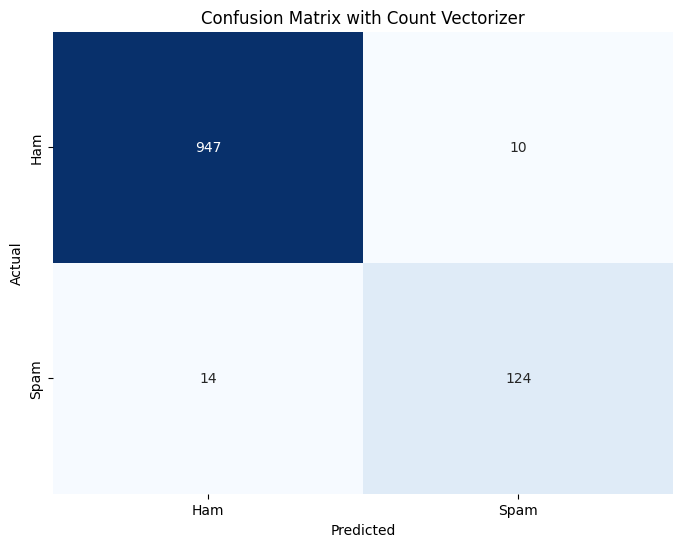

In [227]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_count, annot = True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix with Count Vectorizer')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(70.72222222222221, 0.5, 'Actual')

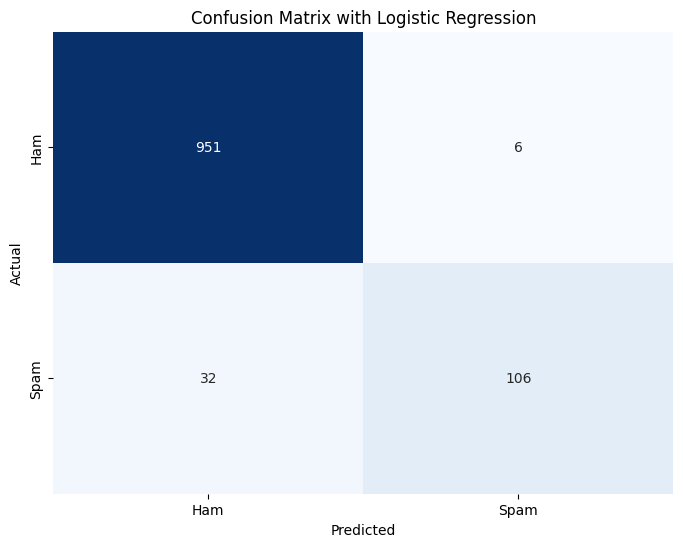

In [228]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_Log, annot = True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.title('Confusion Matrix with Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')